# Matrix Factorization - Notes

We want to express the nxm matrix R as a product of two smaller matrices, i.e., $$\hat{R} = W U^T$$
where W is nXk and U is mxk where k is much smaller than n and m (usually between 10 and 15). This allows us to reduce the memory by storing only $U$ and $W$ instead of large matrix $R$.

This follows from SVD which  generalizes the eigen decomposition of a square normal matrix with an orthonormal eigenbasis to any 
nxm matrix. 

Every element of Matrix $\hat{R}$, i.e., $r_{i,j}$, represents the correspondence (similarity) between row $i$ of $W$ and row $j$ of $U$ matrices.

For instance, in the movie recommendation example, k elements of $W$ may represent features of the movies such as how much action, comedy or other categories the movie contains. Similarly, k elements of $U$ represents how much a user likes actiion, comedy or other elemens in the same order.



## Squared Loss Term

$$ J = \sum_{i,j\in\Omega} (r_{i,j}-\hat{r}_{i,j})^2 = \sum_{i,j\in\Omega} (r_{i,j}- w_i^Tu_j)^2
$$ where $w$ and $u$ are column vectors.

We can use gradient descent algorithm to adjust weights $w$ and $u$ until we converge to optimal loss. Taking the derivative w.r.t $w$ gives
$$\frac{\partial J}{\partial w_i} = -2\sum_{j\in\Psi_i}(r_{ij}- w_i^Tu_j)u_j = 0
$$ the first order condition.
Using this we get,
$$ \sum_{j\in\Psi_i}(w_i^Tu_j)u_j =  \sum_{j\in\Psi_i}r_{ij}u_j\\
\implies w_i = \Bigg(\sum_{j\in\Psi_i} u_ju_j^T\Bigg)^{-1}\sum_{j\in\Psi_i}r_{ij}u_j
$$

This can be solved using numpy `x = np.linalgl.solve(A,b)` which solves $Ax = b$ system of linear equations.
Similarly, since the function is symmetric in u and w, following the same steps, we get
$$u_j = \Bigg(\sum_{i\in\Omega_j} w_iw_i^T\Bigg)^{-1}\sum_{i\in\Omega_j}r_{ij}w_i
$$

We have two-way dependency, the solutions depend on each other. The algorithm will start with random initialization for w and u. In the loop, we use these two formulas to update w and u in sequential order (alternating least squares). At each iteration, the model gets closer to the optimal values, and it does not matter whether we start with u or w first. 

# Training

Alternating Least Squares

$$\hat{r}_{ij} = w_i^Tu_j + b_i+c_j+\mu\\
b_i = \text{ user bias}\\
c_j = \text{ item bias}\\
\mu = \text{ global mean of the train set}$$

User bias and item (e.g., movie,product) bias accounts for the fixed differences of the users and items.

The Loss function can be written as 
$$ J = \sum_{i,j\in\Omega}(r_{ij}-\hat{r}_{ij})^2\\
\hat{r}_{ij}= w_i^Tu_j+b_i+c_j+\mu\\
\implies \frac{\partial J}{\partial w_i} = 2\sum_{j\in\Psi_i}(r_{ij} - w_i^Tu_j- b_i- c_j -\mu)u_j = 0\\
\implies w_i = \Bigg(\sum_{j\in\Psi_i}u_j^Tu_j\Bigg)^{-1}\sum_{j\in\Psi_i}(r_{ij} - b_i- c_j -\mu)u_j$$

Differentiating the loss function with respect to $b_i$, $c_j$, and $u_j$, we can find the their closed form solution in the same way.

# Regularization
Add regularization to matrix factorization to avoid overfitting due to the sparsity of the matrix.

$$J = J = \sum_{i,j\in\Omega}(r_{ij}-\hat{r}_{ij})^2 + \lambda(||U||_F^2+||W||_F^2+||b||_2^2+||c||_2^2)$$
where F stands for Frobenius norm - matrix equivalent of l2 norm.

This helps to avoid having very large weights.

The solution to the first order condition will be as $$
w_i = \Bigg(\sum_{j\in\Psi_i}u_j^Tu_j + \lambda I\Bigg)^{-1}\sum_{j\in\Psi_i}(r_{ij} - b_i- c_j -\mu)u_j$$
wher $I$ stands for the indentity vector.

# Implementation

1. Load the data
2. Initialize the parameters
3. Implement training algorithm to update parameters based on Cost function gradients
4. Calculate MSE for the train/test

### Preprocess the data
1. Preprocess movie and user ids
2. Shrink the dataset by selecting top n users and m movies
3. Convert dataframe to user, movies, and rating dictionaries to represent the sparse rating matrix

In [ ]:
import zipfile
zipref = zipfile.ZipFile('movielens_ratings.zip')
zipref.extractall()
zipref.close()

In [ ]:
import pandas as pd
from collections import Counter

# Read the data
ratings = pd.read_csv('rating.csv')  

In [ ]:
# Preprocess user ids
ratings['userId'] = ratings['userId']-1        
# Preprocess movie ids
movie_ids = {movie:id for id, movie in enumerate(set(ratings.movieId.to_list()))}
ratings['movieId'] = ratings['movieId'].apply(lambda x: movie_ids[x])

In [ ]:
# Select top n users and m movies
n = 5000
m = 1000
top_users = ratings.userId.value_counts().index[:n]
top_movies = ratings.movieId.value_counts().index[:m]

# Create a subset of ratings dataframe with top n and m
subset = ratings[(ratings.userId.isin(top_users))&(ratings.movieId.isin(top_movies))]

# Write the subset dataframe to a csv file
subset.to_csv('small_ratings.csv', index=False)

In [ ]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split

# Load and split the dataset
ratings = pd.read_csv('small_ratings.csv')  # load the subset data
train, test = train_test_split(ratings, test_size = 0.2, shuffle = True)

In [ ]:
# Initialize users, movies, ratings dictionaries
user2movie, movie2user, user_movie_rating = {}, {}, {}

# Create a function to iterate over the rows and update the dictionaries
from tqdm import tqdm
for row in tqdm(train.values):
  if count % 100000 == 0: print("processed: %.3f" % (float(count)/cutoff))
  i,j = row[0], row[1]

  # Update user2movie dictionary
  if i not in user2movie: user2movie[i]=[j]
  else: user2movie[i].append(j)

  # Update movie2user dictionary
  if j not in movie2user: movie2user[j]=[i]
  else: movie2user[j].append(i)

  # Update usermovie2rating
  user_movie_rating[(i,j)] = row[2]

100%|██████████| 1882907/1882907 [00:05<00:00, 337348.53it/s]


In [ ]:
# Update usermovie2rating with test data
user_movie_rating_test = {}
for row in tqdm(test.values):
  i,j = row[0], row[1]
  user_movie_rating_test[(i,j)] = row[2]

100%|██████████| 470727/470727 [00:00<00:00, 578642.83it/s]


In [ ]:
# Confirm the length of the dictionaries are correct
assert len(user2movie)==n
assert  len(movie2user)==m 
assert len(user_movie_rating) + len(user_movie_rating_test) == len(ratings)

In [ ]:
# Save the dictionaries wi th pickle
import joblib
joblib.dump([user2movie, movie2user, user_movie_rating, user_movie_rating_test], 'dictionaries.json')

In [ ]:
# Load the pickled dictionaries
import joblib
user2movie, movie2user, user_movie_rating, user_movie_rating_test = joblib.load('dictionaries.json')

# Covert dictionaries to the suitable form for dot product
import numpy as np
user2movierating = {}
for i, movies in user2movie.items():
  r = np.array([user_movie_rating[(i,j)] for j in movies])
  user2movierating[i] = (movies, r)
movie2userrating = {}
for j, users in movie2user.items():
  r = np.array([user_movie_rating[(i,j)] for i in users])
  movie2userrating[j] = (users, r)

movie2userrating_test = {}
for (i, j), r in user_movie_rating_test.items():
  if j not in user_movie_rating_test:
    movie2userrating_test[j] = [[i], [r]]
  else:
    movie2userrating_test[j][0].append(i)
    movie2userrating_test[j][1].append(r)
for j, (users, r) in movie2userrating_test.items():
  movie2userrating_test[j][1] = np.array(r)

### Alternating Least Squares

This is an implementation of the MF algorithm without from scratch. Since it does not use sparse matrices and vector operations, it is not very scalable, but performs well on smaller datas.

N: 138437 M: 16234
epoch: 0
i: 124587 N: 138437
updated W and b: 0:00:01.658160
updated U and c: 0:00:02.649119
epoch duration: 0:00:04.309051
calculate cost: 0:00:01.767342
train loss: 0.6829113250587309
test loss: 0.6989134488331654
epoch: 1
i: 124587 N: 138437
updated W and b: 0:00:02.432760
updated U and c: 0:00:02.689218
epoch duration: 0:00:05.123483
calculate cost: 0:00:00.932451
train loss: 0.5575207016090408
test loss: 0.5977431235894638
epoch: 2
i: 124587 N: 138437
updated W and b: 0:00:01.653414
updated U and c: 0:00:02.643022
epoch duration: 0:00:04.297387
calculate cost: 0:00:00.901924
train loss: 0.5185630243340791
test loss: 0.5527919589776482
epoch: 3
i: 124587 N: 138437
updated W and b: 0:00:02.609701
updated U and c: 0:00:03.177812
epoch duration: 0:00:05.791872
calculate cost: 0:00:00.888535
train loss: 0.509557666525964
test loss: 0.5373507948379019
epoch: 4
i: 124587 N: 138437
updated W and b: 0:00:01.665575
updated U and c: 0:00:02.567021
epoch duration: 0:00:04.2

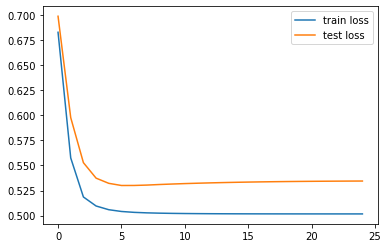

In [ ]:
# Source https://github.com/lazyprogrammer/machine_learning_examples/blob/master/recommenders/mf2.py

# Load the pickled dictionaries
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Get the dimensions of weights and biases
N = np.max(list(user2movie.keys())) + 1
# the test set may contain movies the train set doesn't have data on
m1 = np.max(list(movie2user.keys()))
m2 = np.max([m for (u, m), r in user_movie_rating_test.items()])
M = max(m1, m2) + 1
print("N:", N, "M:", M)

# Initialize variables
K = 10 # latent dimensionality
W = np.random.randn(N, K)
b = np.zeros(N)
U = np.random.randn(M, K)
c = np.zeros(M)
mu = np.mean(list(user_movie_rating.values()))


# Define loss function
def get_loss(m2u):
  # d: movie_id -> (user_ids, ratings)
  N = 0.
  sse = 0
  for j, (u_ids, r) in m2u.items():
    p = W[u_ids].dot(U[j]) + b[u_ids] + c[j] + mu
    delta = p - r
    sse += delta.dot(delta)
    N += len(r)
  return sse / N

# train the parameters
epochs = 25
reg = 20. # regularization penalty
train_losses = []
test_losses = []
for epoch in range(epochs):
  print("epoch:", epoch)
  epoch_start = datetime.now()
  # perform updates

  # update W and b
  t0 = datetime.now()
  for i in user2movierating:
    try:
      m_ids, r = user2movierating[i]
      matrix = U[m_ids].T.dot(U[m_ids]) + np.eye(K) * reg
      vector = (r - b[i] - c[m_ids] - mu).dot(U[m_ids])
      bi = (r - U[m_ids].dot(W[i]) - c[m_ids] - mu).sum()

      # set the updates
      W[i] = np.linalg.solve(matrix, vector)
      b[i] = bi / (len(user2movie[i]) + reg)

      if i % (N//10) == 0:
        print("i:", i, "N:", N)
    except KeyError:
      pass
  print("updated W and b:", datetime.now() - t0)


  # update U and c
  t0 = datetime.now()
  for j in movie2userrating:
    try:
      u_ids, r = movie2userrating[j]
      matrix = W[u_ids].T.dot(W[u_ids]) + np.eye(K) * reg
      vector = (r - b[u_ids] - c[j] - mu).dot(W[u_ids])
      cj = (r - W[u_ids].dot(U[j]) - b[u_ids] - mu).sum()

      # set the updates
      U[j] = np.linalg.solve(matrix, vector)
      c[j] = cj / (len(movie2user[j]) + reg)

      if j % (M//10) == 0:
        print("j:", j, "M:", M)
    except KeyError:
      # possible not to have any ratings for a movie
      pass
  print("updated U and c:", datetime.now() - t0)
  print("epoch duration:", datetime.now() - epoch_start)


  # store train loss
  t0 = datetime.now()
  train_losses.append(get_loss(movie2userrating))

  # store test loss
  test_losses.append(get_loss(movie2userrating_test))
  print("calculate cost:", datetime.now() - t0)
  print("train loss:", train_losses[-1])
  print("test loss:", test_losses[-1])


print("train losses:", train_losses)
print("test losses:", test_losses)

# plot losses
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

# Reimplement Matrix Factorization with Keras
We can try two versions with tensorflow

1. Matrix Factorization with Embedding + Dot product Layer - same algoritm same algorithm as MF

2. Deep nerual network - Embedding layers + Dense layers - Tensorflow Implementation

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input
from sklearn.model_selection import train_test_split

# Load and define params
data = pd.read_csv('small_ratings.csv')
train, test  = train_test_split(data, test_size = 0.2, shuffle = True)
M = data.movieId.max()
N = data.userId.max()
k = 10
reg = 0.1

# Define layers
x1 = Input(shape = ())
x2 = Input(shape = ())  
emb1 = Embedding(input_dim = M, output_dim = k)(x1) # Movie weights
emb1_b = Embedding(input_dim = M, output_dim = 1)(x1) # Movie biases
emb2 = Embedding(input_dim = N, output_dim = k)(x2) # User weights
emb2_b = Embedding(input_dim = N, output_dim = 1)(x2) # User biases
r = tf.keras.layers.Dot(axes = [1,1])([emb1,emb2])  # Dot product of weights
target = tf.keras.layers.add([r, emb1_b, emb2_b]) 

#Combine layers and combine into keras model
model = tf.keras.Model(inputs = [x1,x2], outputs = target)
model.compile(loss = 'huber', optimizer = 'sgd',metrics = ['mae'])


In [ ]:
# To account for global mean we can deduct it from the target value
mu = train.rating.mean()
# Define callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights=True)
history = model.fit(x = [train.movieId.values, train.userId.values], y = train.rating.values,
                    batch_size = 64, epochs = 20,
                    validation_data=([test.movieId.values,test.userId.values],test.rating.values),
                    callbacks = [early_stop]) 

Epoch 1/20
29421/29421 [==============================] - 128s 4ms/step - loss: 2.7859 - mae: 3.2828 - val_loss: 2.5874 - val_mae: 3.0816
Epoch 2/20
29421/29421 [==============================] - 125s 4ms/step - loss: 2.4045 - mae: 2.8962 - val_loss: 2.2127 - val_mae: 2.7017
Epoch 3/20
29421/29421 [==============================] - 134s 5ms/step - loss: 2.0381 - mae: 2.5250 - val_loss: 1.8570 - val_mae: 2.3412
Epoch 4/20
29421/29421 [==============================] - 123s 4ms/step - loss: 1.6956 - mae: 2.1766 - val_loss: 1.5308 - val_mae: 2.0075
Epoch 5/20
29421/29421 [==============================] - 130s 4ms/step - loss: 1.3886 - mae: 1.8605 - val_loss: 1.2466 - val_mae: 1.7121
Epoch 6/20
29421/29421 [==============================] - 122s 4ms/step - loss: 1.1287 - mae: 1.5870 - val_loss: 1.0137 - val_mae: 1.4639
Epoch 7/20
29421/29421 [==============================] - 121s 4ms/step - loss: 0.9216 - mae: 1.3640 - val_loss: 0.8337 - val_mae: 1.2673
Epoch 8/20
29421/29421 [==========

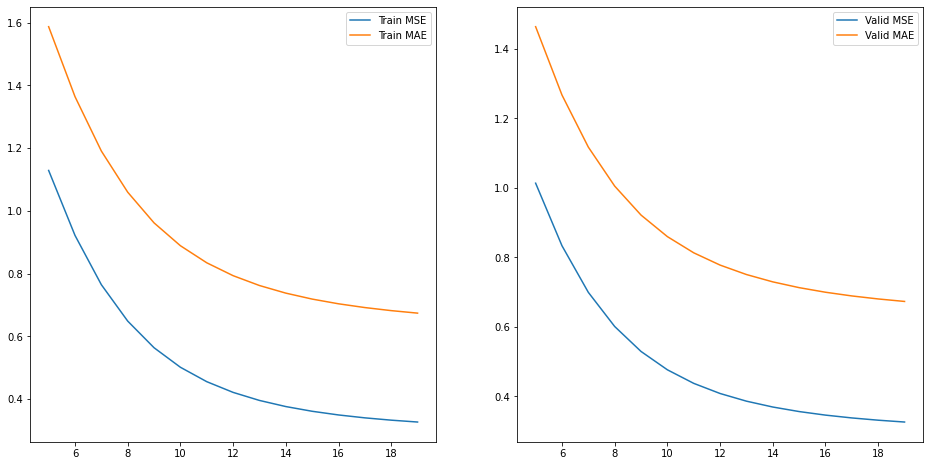

In [ ]:
import matplotlib.pyplot as plt
cutoff = 5
plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
plt.plot(history.epoch[cutoff:], history.history['loss'][cutoff:], label = 'Train Huber')
plt.plot(history.epoch[cutoff:], history.history['mae'][cutoff:], label = 'Train MAE')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.epoch[cutoff:], history.history['val_loss'][cutoff:], label = 'Valid Huber')
plt.plot(history.epoch[cutoff:], history.history['val_mae'][cutoff:], label = 'Valid MAE')
plt.legend()
plt.show()

## ANN Implementation

Here, instead of using Dot product product layer, we concatenate the user and movie embeddings and add dense layers on top of it. Finally, similar to the previous problem, we add an output layer with single neuron for rating predictions.

In [ ]:
# Define layers
k = 20
x1 = Input(shape = ())
x2 = Input(shape = ())  

emb1 = Embedding(input_dim = M, output_dim = k)(x1) # Movie weights
emb2 = Embedding(input_dim = N, output_dim = k)(x2) # User weights
emb1 = tf.keras.layers.Flatten()(emb1)
emb2 = tf.keras.layers.Flatten()(emb2)
emb = tf.keras.layers.concatenate([emb1,emb2])  # Dot product of weights

x = tf.keras.layers.Dense(128, 'elu')(emb)
target = tf.keras.layers.Dense(1, 'relu')(x)

#Combine layers and combine into keras model
model = tf.keras.Model(inputs = [x1,x2], outputs = target)
model.compile(loss = 'huber', optimizer = 'adam', metrics = ['mse','mae'])
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 embedding_40 (Embedding)       (None, 20)           324660      ['input_33[0][0]']               
                                                                                                  
 embedding_41 (Embedding)       (None, 20)           2768720     ['input_34[0][0]']               
                                                                                           

In [ ]:
# Define callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights=True)
history = model.fit(x = [train.movieId.values, train.userId.values], y = train.rating.values,
                    batch_size = 64, epochs = 2,
                    validation_data=([test.movieId.values,test.userId.values],test.rating.values),
                    callbacks = [early_stop]) 

Epoch 1/2
29421/29421 [==============================] - 155s 5ms/step - loss: 0.2978 - mse: 0.6967 - mae: 0.6313 - val_loss: 0.2809 - val_mse: 0.6428 - val_mae: 0.6112
Epoch 2/2
29421/29421 [==============================] - 156s 5ms/step - loss: 0.2772 - mse: 0.6371 - mae: 0.6049 - val_loss: 0.2739 - val_mse: 0.6248 - val_mae: 0.6021


Adding a dense layer and converting the problem to a deep network outperformed the matrix factorization layer without needing to run 20 epochs.

# Probabilistic matrix factorization - Bayesian Approach

Everthing can be considered as a random variables, even our predictions $r_{ij}$.
$$r_{ij}~N(w_i^Tu_j,\sigma^2)\\
p(W)=N(0,\lambda^{-1}), p(u) = N(0,\lambda^{-1})\\
p(W,U|R) = \frac{p(R|W,U)p(W)p(U)}{p(R)}$$

I the bayesian paradigm we do not want to point estimates, but the distributions. 

We want to make predictions using $p(r_{i,j}|R)$. We can calculate $$E(r_{ij}|R) = \int r_{ij}p(r_{ij}|R) \mathrm{d}r_{ij}\\
= \int r_{ij}p(r_{ij}|W,U)p(W,U|R) \mathrm{d}W\mathrm{d}U\mathrm{d}r_{ij} $$

$p(r_{ij}|W,U)$ is our original Gaussian $r_{i,j}~N(w_i^Tu,\sigma^2)$ $$\int r_{ij}p(r_{ij}|W,U)\mathrm{d}r_{ij} = w_i^Tu_j$$ by our modeling assumption.
This allows us to simplify the integral as 
$$E(r_{i,j}|R) = \int w_i^Tu_jp(W,U|R) \mathrm{d}W\mathrm{d}U$$ which is just another expected value, expected value of $w_i^Tu_j$ under the posterior distribuiton of $W$ and $U$. 

Luckily, this expected value can be approximated as the sample mean as long as the sample is drawn from the desired distribution. The method to do this is called Markov Chain Monte Carlo sampling method, the particular algorithm to do this is Gibb's sampling.

$$ E(r_{i,j}|R) = E(w_i^Tu_j|R) = 
\frac{1}{T}\sum_{t=1}^T w_i^{(t)}u_j^{(t)}p$$